In [1]:
from pylab import *
import nylib, nylib2, cjlib, cxlib
import pandas as pd
import mouseProcessing
import B0Correction
import numpy
import cv2
%matplotlib inline

In [2]:
dataPath = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/data/20210119_085051_double_breast_tumors_mice_3_1_1'
field500 = float(nylib.BrukerPar('%s/14'%dataPath, 'acqp','SFO1') )

In [13]:
import datetime
import time
expNumbers = range(0, 20)
expMethod = [None for ii in range(len(expNumbers))]
expRunTime = [None for ii in range(len(expNumbers))]
Comments = [None for ii in range(len(expNumbers))]

for ii, ei in enumerate(expNumbers):
    try:
        expMethod[ii] = nylib.BrukerPar('%s/%s'%(dataPath, ei), 'method', 'Method=')[:-1]        
        timeTemp = str((nylib.searchFile('%s/%s/acqp'%(dataPath, ei), '2021')).split()[1:3])
        timeTemp2 = time.strptime(timeTemp,"['%Y-%m-%d', '%H:%M:%S.%f']")
        timeTemp3 = datetime.datetime.fromtimestamp(time.mktime(timeTemp2))
        expRunTime[ii] = timeTemp3.strftime('%H:%M:%S')
        Comments[ii] = nylib.searchFileNext('%s/%s/pdata/1/visu_pars'%(dataPath, ei), 'VisuSeriesComment=')
            
    except:
        pass
expTable = zip(expNumbers, expMethod, expRunTime, Comments)
df = pd.DataFrame(data = expTable, columns=['ExperimentNumber', 'Method', 'expRunTime','Comment'])
# df = df[df.Method.notnull()]

df['expRunTime'] = (pd.to_datetime(df['expRunTime']))
df['expRunTime'] = df['expRunTime'].dt.time
df.sort_values(by=['expRunTime'])
# print(df.to_string())

,ExperimentNumber,Method,expRunTime,Comment
4,4,<Bruker:FLASH>,09:11:53,None
7,7,<Bruker:RARE>,09:19:00,None
13,13,<User:shim2rdSTEAM>,09:37:25,None
14,14,<User:cestRAREst>,09:42:28,<cestRAREst_DS_0.5uT_4s_10s>
15,15,<User:cestRAREst>,10:00:02,<cestRAREst_DS_2.0uT_4s_10s>
16,16,<User:cestRAREst>,10:15:50,<cestRAREst_DS_1.0uT_4s_10s>
17,17,<User:cestRAREst>,10:30:34,<cestRAREst_DS_0.5uT_4s_10s>
18,18,<Bruker:RAREVTR>,10:34:29,None
19,19,<Bruker:RARE>,10:36:31,None
0,0,None,NaT,None


In [4]:
### define parameters
save_dir = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/new_mice/M1-5/'
wassrNum = 17
cestNum = r_[17, 16, 15]
pulsePowers = r_[0.5, 1.0, 2.0]
T2Num = 19
# T2Slice = 6
roiNum = 7
mouse = 'M1'

# T2

In [6]:
save_dir = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/new_mice/M1-5/'
mouse = 'M1'

# T2
data_T2 = nylib.Paravision2dseqNew('%s/%d'%(dataPath, T2Num))
t2Slice = data_T2
from scipy.io import savemat
savemat(save_dir + "T2.mat", {'T2':t2Slice})



(1, 1, 1, 256, 256)


In [14]:
save_dir = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/new_mice/M1-5/'
mouse = 'M1'

from scipy.io import loadmat
T2 = loadmat(save_dir + "T2.mat")
t2Slice = T2['T2']


(-0.5, 255.5, -0.5, 255.5)

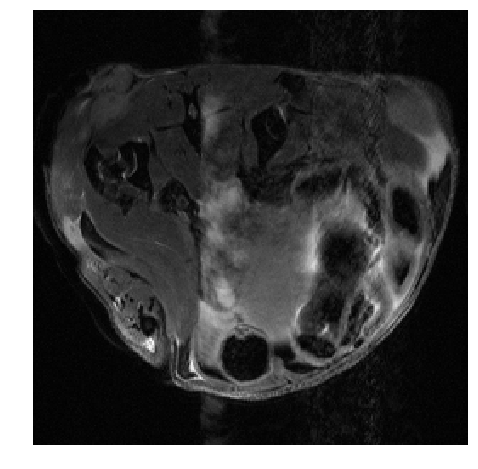

In [8]:
figure(figsize=(8,8))
imshow(fliplr(t2Slice), origin='lower')
gray()
plt.axis('off')

# WASSR

(87, 1, 1, 64, 64)


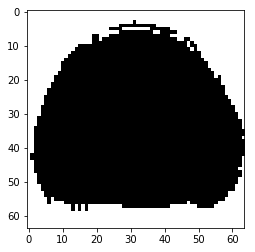

In [9]:
data_temp = nylib.Paravision2dseqNew('%s/%d'%(dataPath, cestNum[0]))
# cjlib.mmontage(data_temp0)
# choose noise
imshow(data_temp[-1]<20)

(87, 1, 1, 64, 64)


/Users/cbie1/opt/anaconda2/envs/python2/lib/python2.7/site-packages/scipy/optimize/minpack.py:447: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


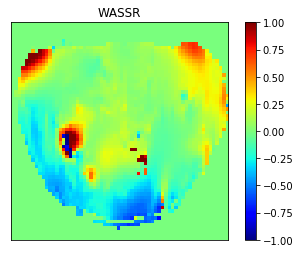

In [10]:
# use 0.3uT as WASSR
reload(B0Correction)
wassrMap,  delta_freq_map= B0Correction.wassrProcessing(dataPath, wassrNum, data_temp[-1]>20)

# cjlib.mimage(wassrMap)
imshow(delta_freq_map/500,origin='lower')
axis('image') # needed so that ginput doesn't resize the image
clim([ percentile(delta_freq_map/500,1) , percentile(delta_freq_map/500, 99) ])
xticks([])
yticks([])
title('WASSR')
    
colorbar()
jet()
clim(-1,1)

# filter noise

In [11]:
#normalization and B0 correction 
reload(mouseProcessing)
reload(B0Correction)
cestData, cestFreq = mouseProcessing.loadMultiData(dataPath, cestNum)

cestDatanoCorrected = zeros((cestData.shape[0], cestData.shape[1]-6, cestData.shape[2], cestData.shape[3]))
cestDatanoCorrected = mouseProcessing.normalizeData(dataPath, cestNum, cestFreq, cestData, data_temp[-1]>20)

cestFreq = cestFreq[:-6]
cestDataCorrected = zeros((cestData.shape[0], cestData.shape[1]-6, cestData.shape[2], cestData.shape[3]))
cestDataCorrected = B0Correction.B0correct(dataPath, cestNum, cestDatanoCorrected, data_temp[-1]>20, delta_freq_map, cestFreq)

print cestFreq

(87, 1, 1, 64, 64)
(87, 1, 1, 64, 64)
(87, 1, 1, 64, 64)
(87, 1, 1, 64, 64)
[-6.004 -5.854 -5.704 -5.554 -5.404 -5.254 -5.104 -4.954 -4.804 -4.652
 -4.502 -4.352 -4.202 -4.052 -3.902 -3.752 -3.602 -3.452 -3.302 -3.152
 -3.002 -2.852 -2.702 -2.552 -2.402 -2.252 -2.102 -1.952 -1.802 -1.652
 -1.5   -1.35  -1.2   -1.05  -0.9   -0.75  -0.6   -0.45  -0.3   -0.15
  0.     0.15   0.3    0.45   0.6    0.75   0.9    1.05   1.2    1.35
  1.5    1.652  1.802  1.952  2.102  2.252  2.402  2.552  2.702  2.852
  3.002  3.152  3.302  3.452  3.602  3.752  3.902  4.052  4.202  4.352
  4.502  4.652  4.804  4.954  5.104  5.254  5.404  5.554  5.704  5.854
  6.004]


In [9]:
from scipy.io import savemat
savemat(save_dir + "cestData.mat", {'cestData':cestData})
savemat(save_dir + "cestDataCorrected.mat", {'cestDataCorrected':cestDataCorrected})
savemat(save_dir + "cestFreq.mat", {'cestFreq':cestFreq})



In [12]:
import scipy.io
cestData = scipy.io.loadmat(save_dir +  'cestData.mat')
cestData = cestData['cestData']

cestDataCorrected = scipy.io.loadmat(save_dir +  'cestDataCorrected.mat')
cestDataCorrected = cestDataCorrected['cestDataCorrected']

cestFreq = scipy.io.loadmat(save_dir +  'cestFreq.mat')
cestFreq = squeeze(cestFreq['cestFreq'])

In [9]:
reload(cxlib)

cestDataCorrectedFilter = cxlib.image_filter(cestDataCorrected,3)

# Z-spectra analysis

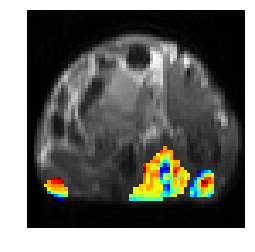

In [10]:
# choose whole tumor
MDA_MB_231_whole = [(11.433333333333332, 53.36666666666667), (10.83333333333333, 54.03333333333333), (9.766666666666664, 54.166666666666664), (8.299999999999995, 54.166666666666664), (7.233333333333329, 53.699999999999996), (5.099999999999996, 52.3), (4.4999999999999964, 50.766666666666666), (4.4999999999999964, 49.1), (5.433333333333332, 48.03333333333333), (6.366666666666662, 47.03333333333333), (7.83333333333333, 47.1), (9.099999999999996, 47.5), (10.366666666666662, 48.7), (11.03333333333333, 50.36666666666667), (11.433333333333332, 51.43333333333333), (11.566666666666665, 52.43333333333333)]
MCF_7_whole = [(54.966666666666654, 54.43333333333333), (54.5, 54.63333333333333), (53.633333333333326, 55.03333333333333), (52.76666666666666, 55.166666666666664), (50.43333333333333, 55.166666666666664), (48.96666666666666, 55.166666666666664), (48.96666666666666, 52.36666666666667), (49.633333333333326, 50.833333333333336), (50.033333333333324, 49.833333333333336), (50.633333333333326, 48.833333333333336), (52.033333333333324, 48.7), (53.83333333333333, 48.766666666666666), (54.5, 49.766666666666666), (54.766666666666666, 51.699999999999996), (54.766666666666666, 52.63333333333333), (54.766666666666666, 53.233333333333334)]
Muscle_whole = [(39.76666666666666, 55.36666666666667), (38.03333333333333, 55.699999999999996), (34.96666666666666, 56.1), (31.43333333333333, 55.9), (28.83333333333333, 55.1), (28.166666666666664, 53.833333333333336), (29.233333333333327, 50.9), (31.499999999999993, 49.833333333333336), (32.96666666666666, 48.833333333333336), (32.96666666666666, 44.9), (32.96666666666666, 43.7), (34.099999999999994, 42.63333333333333), (35.3, 41.36666666666667), (36.76666666666666, 40.1), (38.23333333333333, 38.63333333333333), (39.76666666666666, 37.9), (42.033333333333324, 39.7), (42.89999999999999, 41.43333333333333), (44.76666666666666, 42.96666666666667), (45.633333333333326, 44.63333333333333), (47.3, 46.1), (47.83333333333333, 47.5), (47.76666666666666, 49.56666666666666), (46.76666666666666, 51.36666666666667), (45.23333333333333, 53.43333333333333), (43.36666666666666, 54.3), (41.36666666666666, 54.56666666666666)]
# [(42.699999999999996, 54.233333333333334), (41.633333333333326, 54.233333333333334), (38.96666666666666, 54.96666666666667), (36.76666666666666, 55.166666666666664), (34.49999999999999, 55.36666666666667), (31.83333333333333, 55.43333333333333), (29.83333333333333, 55.43333333333333), (28.89999999999999, 53.9), (29.633333333333326, 52.1), (31.566666666666663, 50.3), (33.23333333333333, 49.166666666666664), (33.3, 47.3), (33.3, 45.43333333333333), (33.43333333333333, 43.166666666666664), (34.099999999999994, 41.43333333333333), (36.166666666666664, 39.63333333333333), (38.36666666666666, 38.233333333333334), (41.033333333333324, 38.233333333333334), (43.166666666666664, 39.7), (44.96666666666666, 41.3), (45.89999999999999, 44.43333333333333), (47.43333333333333, 46.96666666666667), (48.099999999999994, 49.63333333333333), (46.89999999999999, 51.43333333333333), (45.49999999999999, 53.63333333333333), (43.96666666666666, 53.96666666666667)]

MDA_MB_231_whole = [(x[0]-0, x[1]+1) for x in MDA_MB_231_whole]
MCF_7_whole = [(x[0]+0, x[1]-1) for x in MCF_7_whole]


# get the mask and erosion
MDA_mask_whole = nylib2.roipolyny(cestDataCorrected[0], MDA_MB_231_whole)
MCF_mask_whole = nylib2.roipolyny(cestDataCorrected[0], MCF_7_whole)
muscle_mask_mask = nylib2.roipolyny(cestDataCorrected[0], Muscle_whole)

kernel = np.ones((2,2),np.uint8)
MDA_mask_whole = cv2.erode(MDA_mask_whole,kernel,iterations = 1)
# MCF_mask_whole = cv2.erode(MCF_mask_whole,kernel,iterations = 1)
muscle_mask_mask = cv2.erode(muscle_mask_mask,kernel,iterations = 2)

# show ROI
imshow(cestData[-1,-1])
gray()

maskedRoi = ma.masked_array(cestData[-1,-1], mask=(MDA_mask_whole==0))
imshow(maskedRoi)
jet()

maskedRoi = ma.masked_array(cestData[-1,-1], mask=(MCF_mask_whole==0))
imshow(maskedRoi)
jet()

maskedRoi = ma.masked_array(cestData[-1,-1], mask=(muscle_mask_mask==0))
imshow(maskedRoi)
jet()

axis('off')

mask_MDA_MB_231 = MDA_mask_whole
mask_MCF_7 = MCF_mask_whole
mask_muscle_backr = muscle_mask_mask

In [11]:
# Z-spectra
pulsePowers = r_[0.5, 1.0, 2.0]

data_pulsePowerDependence_masked = zeros((cestDataCorrectedFilter.shape[0], 3, cestDataCorrectedFilter.shape[1]))

for ii in range(len(pulsePowers)):    
    data_pulsePowerDependence_masked[ii, 0] = nylib2.applyMask(cestDataCorrected[ii], mask_MDA_MB_231)   
    data_pulsePowerDependence_masked[ii, 1] = nylib2.applyMask(cestDataCorrected[ii], mask_MCF_7)
    data_pulsePowerDependence_masked[ii, 2] = nylib2.applyMask(cestDataCorrected[ii], mask_muscle_backr)

# compare different ROIs

/Users/cbie1/opt/anaconda2/envs/python2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'S/S$_0$')

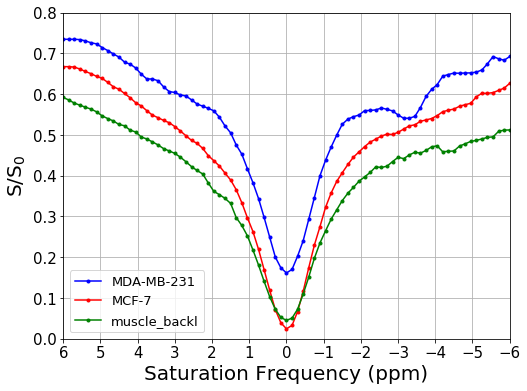

In [12]:
# plot Z-spectra
figure(figsize=(8,6))

tag = 2
plot(cestFreq, data_pulsePowerDependence_masked[tag+0,0], 'b.-', label='MDA-MB-231')
plot(cestFreq, data_pulsePowerDependence_masked[tag+0,1], 'r.-', label='MCF-7')
plot(cestFreq, data_pulsePowerDependence_masked[tag+0,2], 'g.-', label='muscle_backl')

grid('on')
ylim(0, .8)
xlim(6,-6)
xticks([6, 5, 4, 3, 2,1, 0, -1, -2, -3, -4, -5, -6])
legend(loc='lower left',fontsize=13)
tick_params(labelsize=15)
xlabel('Saturation Frequency (ppm)',fontsize=20)
ylabel('S/S$_0$',fontsize=20)

Text(0,0.5,'S/S$_0$')

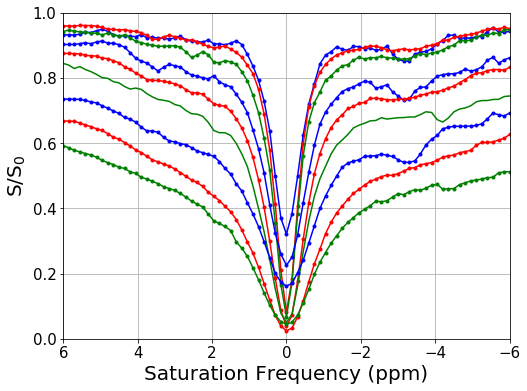

In [13]:
# plot Z-spectra
figure(figsize=(8,6))


plot(cestFreq, data_pulsePowerDependence_masked[0,0], 'b.-', label='MDA-MB-231')
plot(cestFreq, data_pulsePowerDependence_masked[0,1], 'r.-', label='MCF-7')
plot(cestFreq, data_pulsePowerDependence_masked[0,2], 'g.-', label='MCF-7')

plot(cestFreq, data_pulsePowerDependence_masked[1,0], 'b.-', label='MDA-MB-231')
plot(cestFreq, data_pulsePowerDependence_masked[1,1], 'r.-', label='MCF-7')
plot(cestFreq, data_pulsePowerDependence_masked[1,2], 'g-', label='MCF-7')

plot(cestFreq, data_pulsePowerDependence_masked[2,0], 'b.-', label='MDA-MB-231')
plot(cestFreq, data_pulsePowerDependence_masked[2,1], 'r.-', label='MCF-7')
plot(cestFreq, data_pulsePowerDependence_masked[2,2], 'g.-', label='MCF-7')



grid('on')
ylim(0, 1)
xlim(6,-6)
# legend(loc='lower left',fontsize=13)
tick_params(labelsize=15)
xlabel('Saturation Frequency (ppm)',fontsize=20)
ylabel('S/S$_0$',fontsize=20)

In [29]:
# # # save 1s data
# Ztab_MDA_MB_231 = zeros((3, len(cestFreq)))
# Ztab_MDA_MB_231[0] = data_pulsePowerDependence_masked[0,0]
# Ztab_MDA_MB_231[1] = data_pulsePowerDependence_masked[1,0]
# Ztab_MDA_MB_231[2] = data_pulsePowerDependence_masked[2,0]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_Ztab_MDA_MB_231.mat", {'Ztab_MDA_MB_231':Ztab_MDA_MB_231})

# Ztab_MCF_7 = zeros((3, len(cestFreq)))
# Ztab_MCF_7[0] = data_pulsePowerDependence_masked[0,1]
# Ztab_MCF_7[1] = data_pulsePowerDependence_masked[1,1]
# Ztab_MCF_7[2] = data_pulsePowerDependence_masked[2,1]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_Ztab_MCF_7.mat", {'Ztab_MCF_7':Ztab_MCF_7})

# Ztab_Muscle_back = zeros((3, len(cestFreq)))
# Ztab_Muscle_back[0] = data_pulsePowerDependence_masked[0,2]
# Ztab_Muscle_back[1] = data_pulsePowerDependence_masked[1,2]
# Ztab_Muscle_back[2] = data_pulsePowerDependence_masked[2,2]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_Ztab_Muscle_back.mat", {'Ztab_Muscle':Ztab_Muscle_back})


# from scipy.io import savemat
# savemat(save_dir + "_offset.mat", {'cestFreq':cestFreq})


In [14]:
# select frequency
inds_sat = np.nonzero( cestFreq < (cestFreq.max()+1) )[0] 
fitinds = np.hstack((np.where( (cestFreq > 0.01) * (cestFreq < 1.) ),
                        np.where( (cestFreq > -1.) * (cestFreq < -0.01) ),
                        np.where( (cestFreq > cestFreq.max()-0.6) )))[0]

In [15]:
reload(cxlib)

lorentz_fitting = zeros((data_pulsePowerDependence_masked.shape[0], data_pulsePowerDependence_masked.shape[1], data_pulsePowerDependence_masked.shape[2]))
lorDiff = zeros((data_pulsePowerDependence_masked.shape[0], data_pulsePowerDependence_masked.shape[1], data_pulsePowerDependence_masked.shape[2]))

for ii in range(data_pulsePowerDependence_masked.shape[0]):
    for ij in range(data_pulsePowerDependence_masked.shape[1]):
        data = data_pulsePowerDependence_masked[ii,ij]
#         newfreq, mm_fixed, lorentz_fitting[ii,ij], At, x0t, wt, bt, kt = cjlib.cestFit( cestFreq[inds_sat], data[inds_sat], fitinds, cestFreq[inds_sat])
        lorentz_fitting[ii, ij]  = cxlib.freqDomainShift(cestFreq, data)[0]
        lorDiff[ii,ij] = lorentz_fitting[ii,ij] - data

MTRasym =  zeros((data_pulsePowerDependence_masked.shape[0], data_pulsePowerDependence_masked.shape[1], (data_pulsePowerDependence_masked.shape[2]-1)/2))
for ii in range(data_pulsePowerDependence_masked.shape[0]):
    for ij in range(data_pulsePowerDependence_masked.shape[1]):
        data = data_pulsePowerDependence_masked[ii,ij]
        asymFreq, MTRasym[ii,ij] = cxlib.asymAnalysis(cestFreq, data)

In [16]:
# # save 1s data
# LD_MDA_MB_231 = zeros((3, len(cestFreq)))
# LD_MDA_MB_231[0] = lorDiff[0,0]
# LD_MDA_MB_231[1] = lorDiff[1,0]
# LD_MDA_MB_231[2] = lorDiff[2,0]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_LD_MDA_MB_231.mat", {'LD_MDA_MB_231':LD_MDA_MB_231})

# LD_MCF_7 = zeros((3, len(cestFreq)))
# LD_MCF_7[0] = lorDiff[0,1]
# LD_MCF_7[1] = lorDiff[1,1]
# LD_MCF_7[2] = lorDiff[2,1]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_LD_MCF_7.mat", {'LD_MCF_7':LD_MCF_7})

# LD_Muscle_back = zeros((3, len(cestFreq)))
# LD_Muscle_back[0] = lorDiff[0,2]
# LD_Muscle_back[1] = lorDiff[1,2]
# LD_Muscle_back[2] = lorDiff[2,2]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_LD_Muscle_back.mat", {'LD_Muscle':LD_Muscle_back})


# # save 1s data
# MTR_MDA_MB_231 = zeros((3, len(asymFreq)))
# MTR_MDA_MB_231[0] = MTRasym[0,0]
# MTR_MDA_MB_231[1] = MTRasym[1,0]
# MTR_MDA_MB_231[2] = MTRasym[2,0]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_MTR_MDA_MB_231.mat", {'MTR_MDA_MB_231':MTR_MDA_MB_231})

# MTR_MCF_7 = zeros((3, len(asymFreq)))
# MTR_MCF_7[0] = MTRasym[0,1]
# MTR_MCF_7[1] = MTRasym[1,1]
# MTR_MCF_7[2] = MTRasym[2,1]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_MTR_MCF_7.mat", {'MTR_MCF_7':MTR_MCF_7})

# MTR_Muscle_back = zeros((3, len(asymFreq)))
# MTR_Muscle_back[0] = MTRasym[0,2]
# MTR_Muscle_back[1] = MTRasym[1,2]
# MTR_Muscle_back[2] = MTRasym[2,2]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_MTR_Muscle_back.mat", {'MTR_Muscle_back':MTR_Muscle_back})


# from scipy.io import savemat
# savemat(save_dir + "MTRasym_offset.mat", {'asymFreq':asymFreq})


([<matplotlib.axis.XTick at 0x7fc493bfa250>,
 <a list of 7 Text xticklabel objects>)

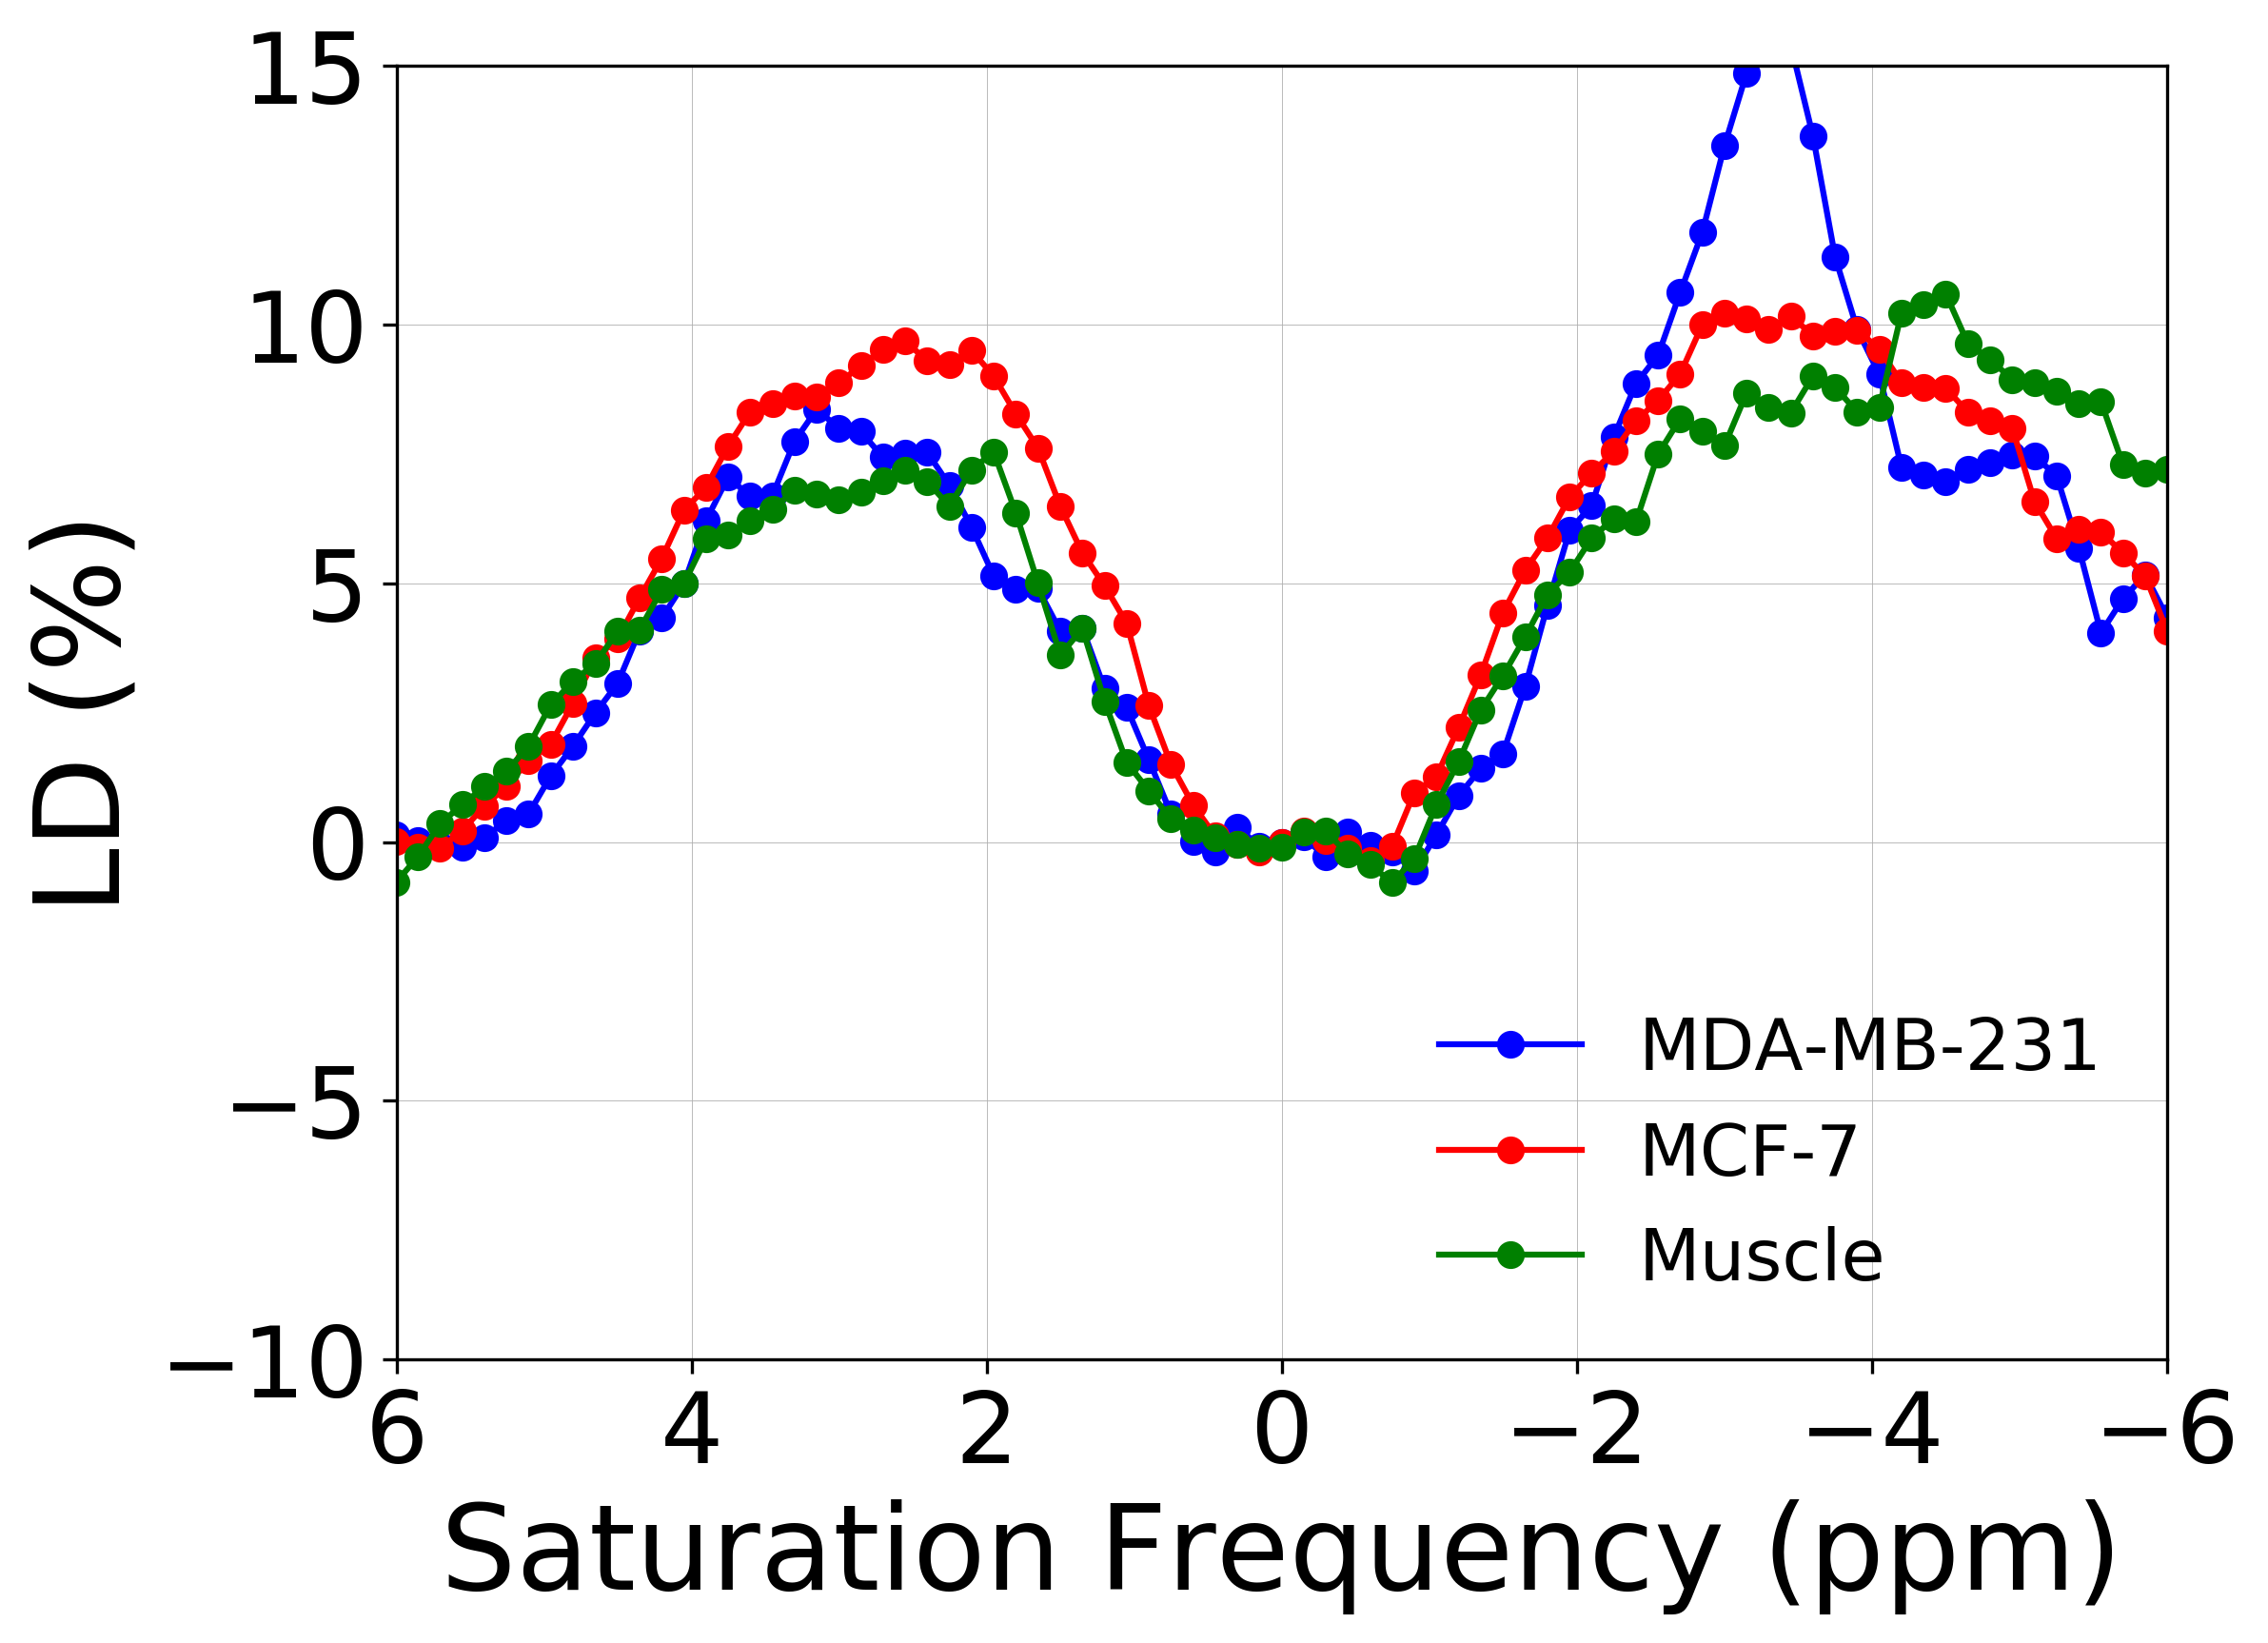

In [18]:
# figure(figsize=(8,6))
figure(figsize=(8,6),dpi=300)
tag = 0
plot(cestFreq, lorDiff[2,0]*100, 'bo-', label='MDA-MB-231')
plot(cestFreq, lorDiff[2,1]*100, 'ro-', label='MCF-7')
plot(cestFreq, lorDiff[2,2]*100, 'go-', label='Muscle')
# plot(cestFreq, lorentz_fitting[tag, 2]*100 - data_pulsePowerDependence_masked[tag, 2]*100, 'go-', label='Muscle')

ylim(-10, 15)
xlim(6,-6)
tick_params(labelsize=25)
grid('on',linewidth=0.2)

legend(loc='lower right',frameon=False, fontsize=18)
xlabel('Saturation Frequency (ppm)',fontsize=30)
# xlabel(u'\u0394'+u'\u03C9',fontsize=15)
ylabel('LD (%)',fontsize=30)
xticks([6, 4, 2, 0, -2, -4, -6])
# xticks([6, 5, 4, 3, 2,1, 0, -1, -2, -3, -4, -5, -6])

([<matplotlib.axis.XTick at 0x7fc478755c10>,
 <a list of 7 Text xticklabel objects>)

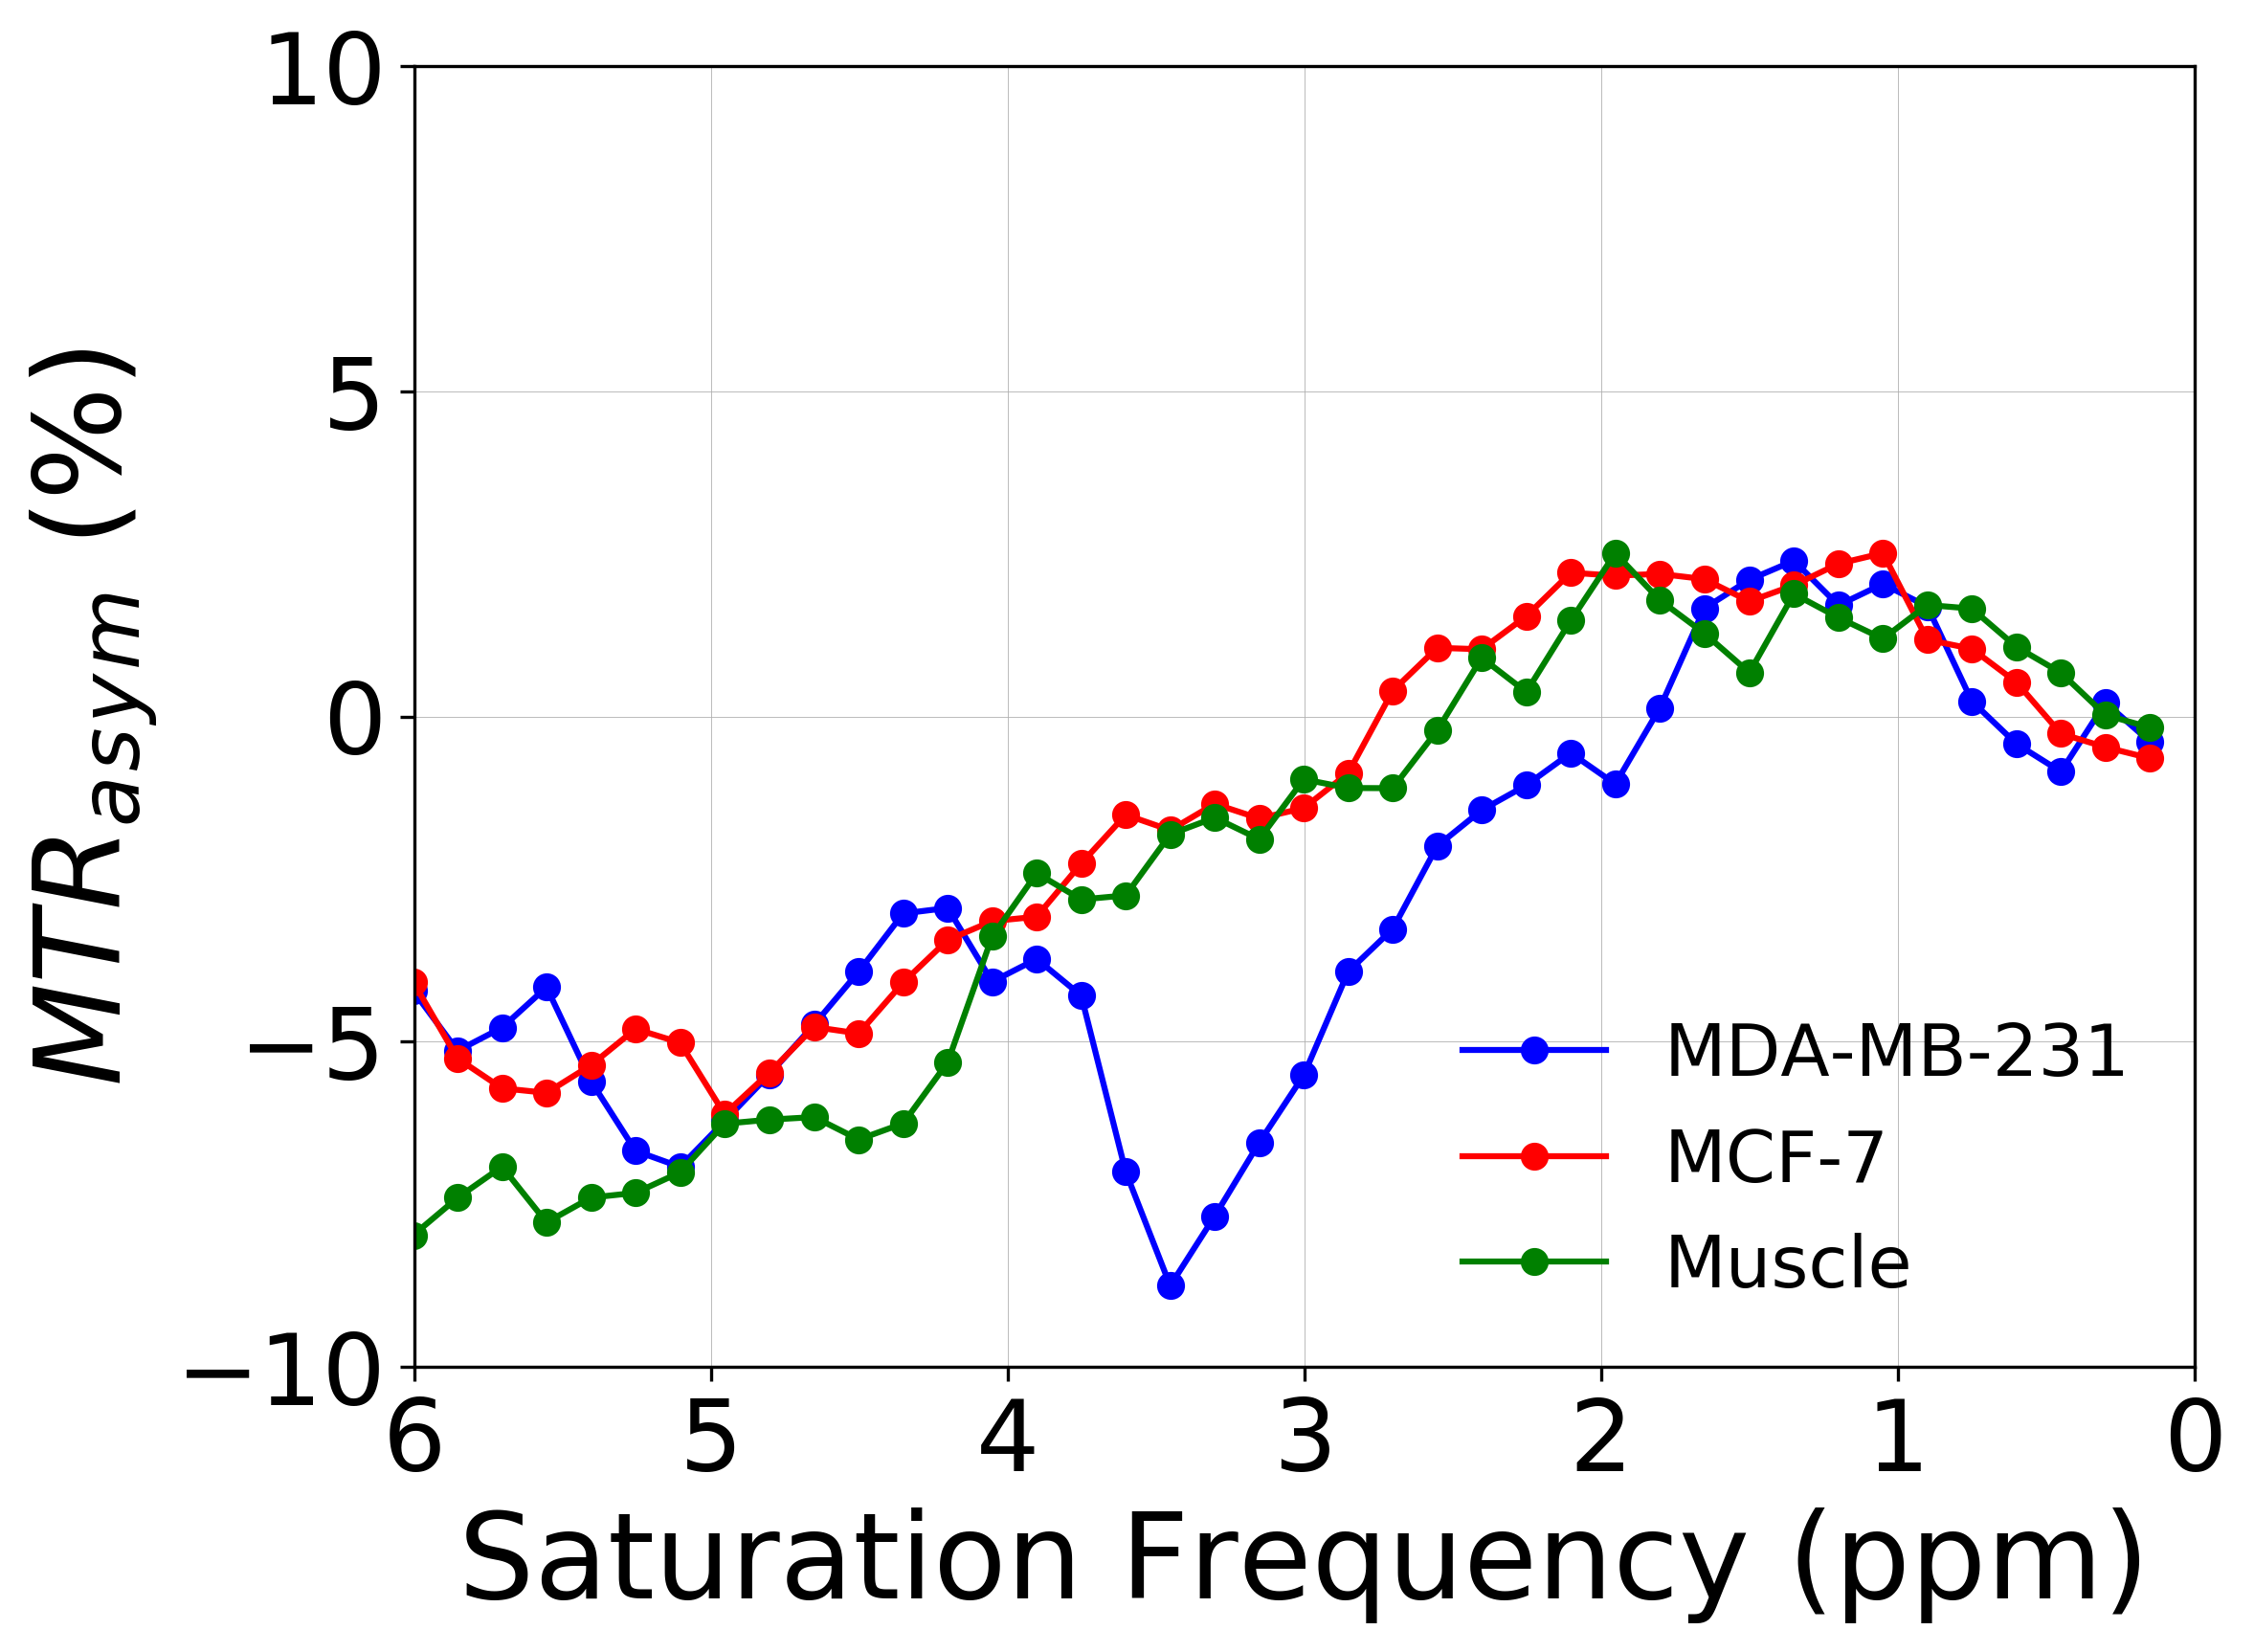

In [19]:
# figure(figsize=(8,6))
figure(figsize=(8,6),dpi=300)
# subplot(121)
# title('0.5uT 4th mouse double tumor')

plot(asymFreq, MTRasym[2,0]*100, 'bo-', label='MDA-MB-231')
plot(asymFreq, MTRasym[2,1]*100, 'ro-', label='MCF-7')
plot(asymFreq, MTRasym[2,2]*100, 'go-', label='Muscle')

ylim(-10, 10)
xlim(6,0)
grid('on',linewidth=0.2)
tick_params(labelsize=25)
legend(loc='lower right',frameon=False, fontsize=18)
xlabel('Saturation Frequency (ppm)',fontsize=30)
# xlabel(u'\u0394'+u'\u03C9',fontsize=15)
ylabel('${MTR_a}{_s}{_y}{_m}$ (%)',fontsize=30)
xticks([6, 5, 4, 3,2, 1,0])
# xticks([6, 5, 4, 3, 2,1, 0])

In [20]:
mask1 = np.ma.mask_or(MDA_mask_whole, MCF_mask_whole)
mask2 = np.ma.mask_or(MCF_mask_whole, muscle_mask_mask)
mask = np.ma.mask_or(mask1, mask2)

In [21]:
reload(cxlib)
highFreq = 6.1
lowFreq = -6.1
Data = cestDataCorrected[2]
LDcest, indsFreq = cxlib.LDMap(cestFreq, Data, lowFreq, highFreq)
asym, asymFreq = cxlib.asymMap(cestFreq, Data, lowFreq, highFreq)

In [22]:
def CEST_Avg(cestData, indsFreq, beginFreq, endFreq):
    Inds = where((indsFreq>=beginFreq) & (indsFreq<=endFreq))
    cest_Avg = zeros((cestData.shape[1],cestData.shape[2]))
   
    for ii in Inds[0]:
        cest_Avg = add(cest_Avg, cestData[ii])
    cest_Avg  = cest_Avg / len(Inds[0])
    return cest_Avg

[Text(1,0,'0%'), Text(1,0,'5%'), Text(1,0,'10%'), Text(1,0,'15%')]

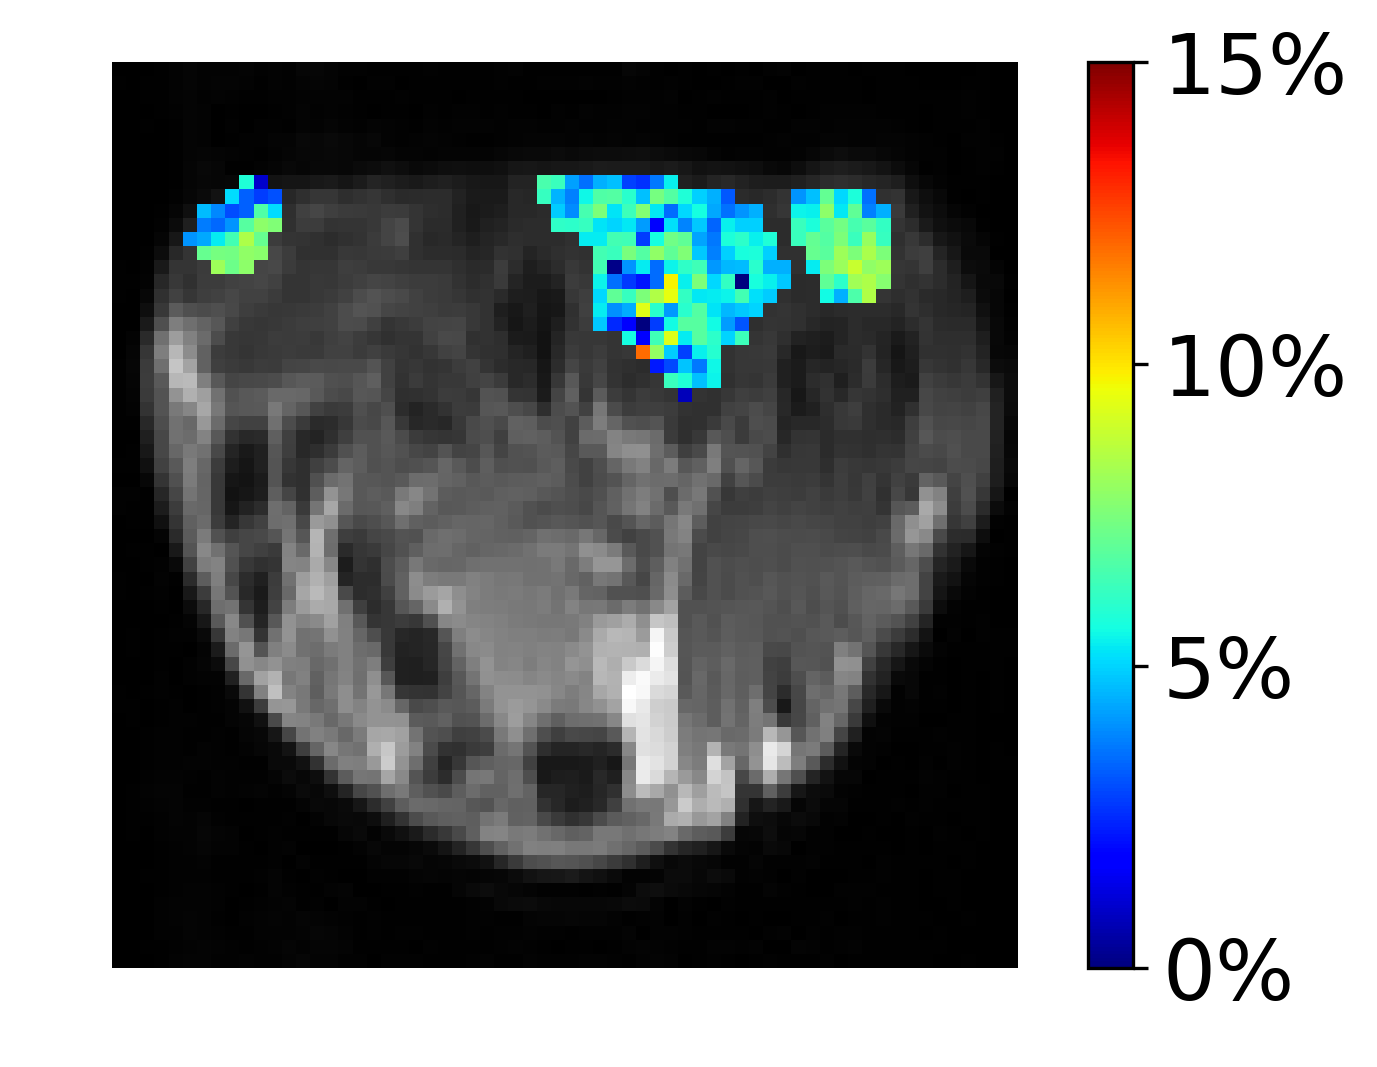

In [23]:
# show LD map at 2, 3.5, 4 ppm
import os,sys
scriptpath = "/Users/cbie1/Documents/pythonLibrary/colormap-master/"
sys.path.append(os.path.abspath(scriptpath))
import colormaps as cmaps


lLim = 0.0
hLim = 0.15

# beginFreq = 1.9
# endFreq = 1.95

beginFreq = 3.5
endFreq = 3.6

# beginFreq = 4.
# endFreq = 4.1


cest_LD_Avg = CEST_Avg(LDcest, indsFreq, beginFreq, endFreq)

# fig, ax = plt.subplots()
fig, ax = plt.subplots(dpi=300)

cax = plt.imshow(cestData[1,-1],origin='lower', cmap='gray')

maskedRoi = ma.masked_array(cest_LD_Avg, mask=(mask==0))
cax = plt.imshow(maskedRoi, origin='lower')
jet()

plt.axis('off')
plt.clim(lLim, hLim)

# cbar = fig.colorbar(cax, ticks=[0., 0.05, 0.10, 0.15])
# cbar.ax.set_yticklabels(['0%', '5%', '10%', '15%'],fontsize=20) 

[Text(1,0,'0%'),
 Text(1,0,'5%'),
 Text(1,0,'10%'),
 Text(1,0,'15%'),
 Text(1,0,'20%')]

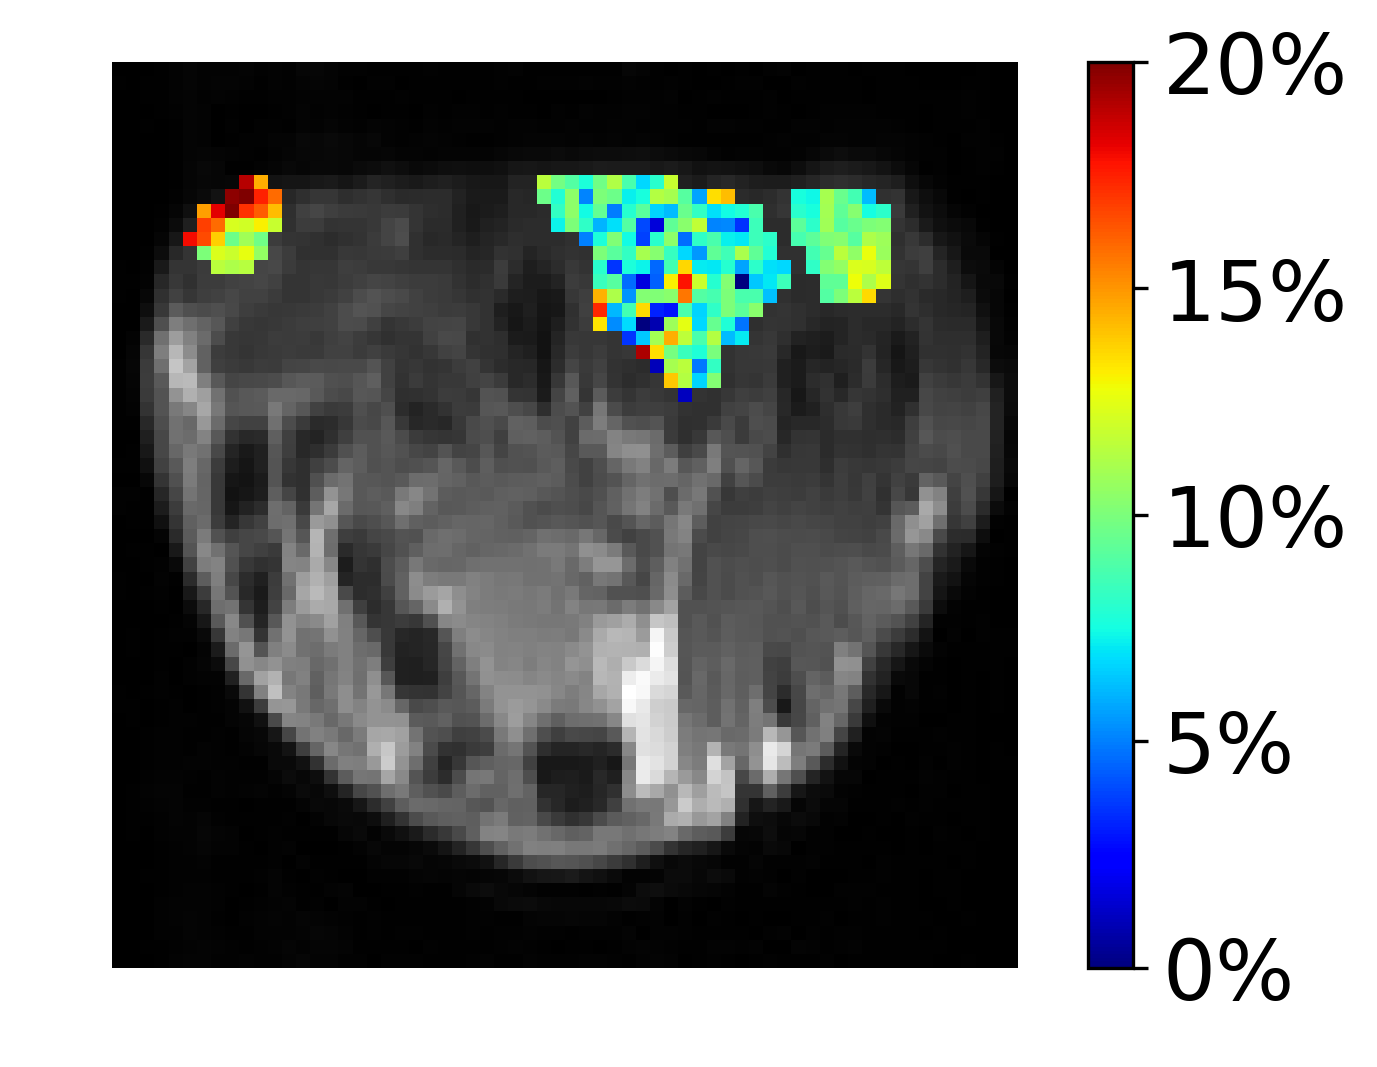

In [24]:
###### show LD map at -3.5ppm
lLim = 0
hLim = 0.2

beginFreq = -3.5
endFreq = -3.4

cest_LD_Avg = CEST_Avg(LDcest, indsFreq, beginFreq, endFreq)

fig, ax = plt.subplots(dpi=300)

cax = imshow(cestData[1,-1])
gray()
maskedRoi = ma.masked_array(cest_LD_Avg, mask=(mask==0))
cax = imshow(maskedRoi, origin='lower')
jet()

plt.axis('off')
plt.clim(lLim, hLim)

cbar = fig.colorbar(cax, ticks=[0., 0.05, 0.1, 0.15, 0.20])
cbar.ax.set_yticklabels(['0%', '5%', '10%', '15%','20%'],fontsize=20) 

[Text(1,0,'-10%'),
 Text(1,0,'-5%'),
 Text(1,0,'0%'),
 Text(1,0,'5%'),
 Text(1,0,'10%')]

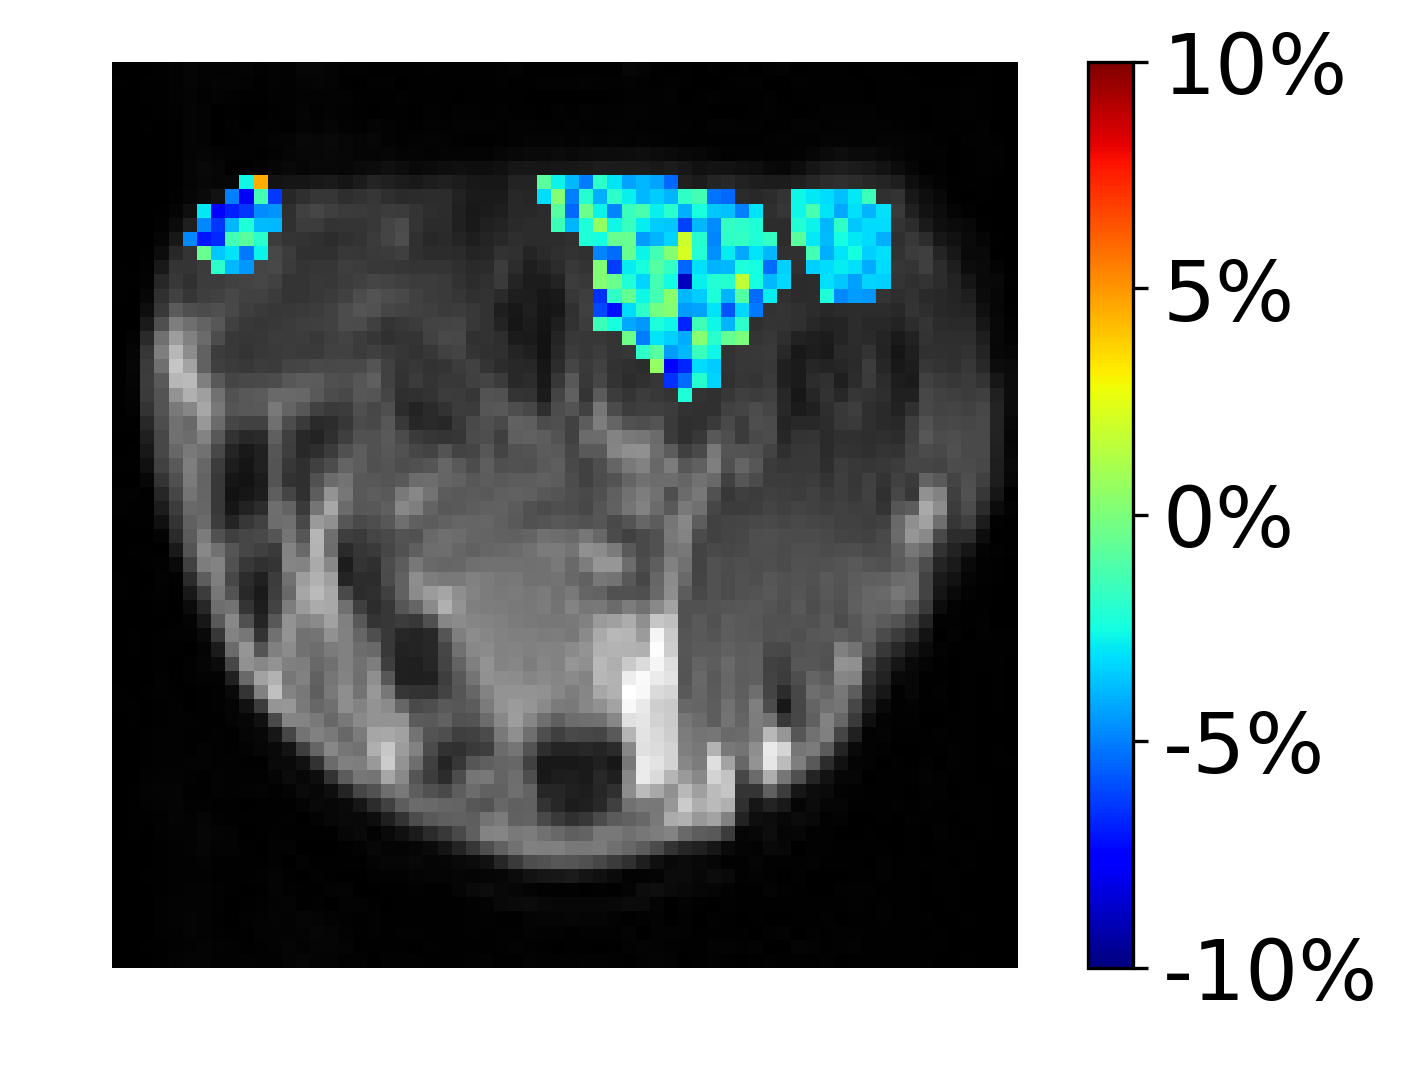

In [25]:
# show MTRasym map at 2, 3.5, 4 ppm
lLim = -0.1
hLim = 0.1


# beginFreq = 1.9
# endFreq = 1.95


beginFreq = 3.5
endFreq = 3.6

# beginFreq = 4.
# endFreq = 4.1



cest_asym_Avg = CEST_Avg(asym, asymFreq, beginFreq, endFreq)

fig, ax = plt.subplots(dpi=300)

cax = imshow(cestData[1,-1])
gray()
maskedRoi = ma.masked_array(cest_asym_Avg, mask=(mask==0))
cax = imshow(maskedRoi, origin='lower')
jet()

plt.axis('off')
plt.clim(lLim, hLim)


# cbar = fig.colorbar(cax, ticks=[-0.1, -0.05,  0, 0.05, 0.1])
# cbar.ax.set_yticklabels(['-10%', '-5%', '0%', '5%', '10%'], fontsize=20) 



# PCA-based denoising and save

In [26]:
# tumor
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Data_Right_Tumor = []
for ii in range(MDA_mask_whole.shape[0]):
    for ij in range(MDA_mask_whole.shape[1]):
        if MDA_mask_whole[ii, ij] == True:
            Data_Right_Tumor.append(cestDataCorrectedFilter[2, :, ii, ij])
Data_Right_Tumor = array(Data_Right_Tumor)
Index_Right_Tumor = zeros((Data_Right_Tumor.shape[0]))

In [27]:
# tumor
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Data_Left_Tumor = []
for ii in range(MCF_mask_whole.shape[0]):
    for ij in range(MCF_mask_whole.shape[1]):
        if MCF_mask_whole[ii, ij] == True:
            Data_Left_Tumor.append(cestDataCorrectedFilter[2, :, ii, ij])
Data_Left_Tumor = array(Data_Left_Tumor)
Index_Left_Tumor = zeros((Data_Left_Tumor.shape[0]))+1

In [28]:
# tumor
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Data_Tissue = []
for ii in range(muscle_mask_mask.shape[0]):
    for ij in range(muscle_mask_mask.shape[1]):
        if muscle_mask_mask[ii, ij] == True:
            Data_Tissue.append(cestDataCorrectedFilter[2, :, ii, ij])
Data_Tissue = array(Data_Tissue)
Index_Tissue = zeros((Data_Tissue.shape[0]))+2

In [29]:
Data_cest = []
Data_cest += list(Data_Right_Tumor)
Data_cest += list(Data_Left_Tumor)
Data_cest += list(Data_Tissue)
Data_cest = array(Data_cest)

Index =[]
Index += list(Index_Right_Tumor)
Index += list(Index_Left_Tumor)
Index += list(Index_Tissue)
Index = array(Index)

In [30]:
# numpy.savetxt(save_dir + mouse + 'whole_sep_2pt_filter.csv', Data_cest, delimiter = ',')

# data = Data_cest
# data_PCA, eigen_value, var = cxlib.PCA_denoising(data,3,98)
# numpy.savetxt(save_dir + mouse + 'whole_sep_2pt_denoising_filter.csv', data_PCA, delimiter = ',')

# numpy.savetxt(save_dir + mouse + 'whole_sep_2pt_denoising_filter_index.csv', Index, delimiter = ',')

In [35]:
# save_dir = '/Users/cbie1/OneDrive - Johns Hopkins/JHU/CEST/Machine_Learning_BreastTumor/double_tumor/material_paper/20200824/M1_3/'

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2+1uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2+1+05uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2+05uT_1.csv', delimiter = ',')

Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_1+05uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_1uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_05uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_uneven_2uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_uniform_2uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2uT_LD_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2uT_MTR_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2uT_LD_MTR_1.csv', delimiter = ',')

right_Tumor_Pred_cnn = Pred_cnn[0:len(Data_Right_Tumor)]
left_Tumor_Pred_cnn = Pred_cnn[len(Data_Right_Tumor): len(Data_Right_Tumor)+len(Data_Left_Tumor)]
tissue_Pred_cnn = Pred_cnn[len(Data_Right_Tumor)+len(Data_Left_Tumor):]

map_Pred_Right_Tumor_cnn = zeros((MDA_mask_whole.shape[0], MDA_mask_whole.shape[1]))
map_Pred_Right_False_Left_Tumor_cnn = zeros((MDA_mask_whole.shape[0], MDA_mask_whole.shape[1]))
map_Pred_Right_False_Tissue_Tumor_cnn = zeros((MDA_mask_whole.shape[0], MDA_mask_whole.shape[1]))

map_Pred_Left_Tumor_cnn = zeros((MCF_mask_whole.shape[0], MCF_mask_whole.shape[1]))
map_Pred_Left_False_Right_Tumor_cnn = zeros((MCF_mask_whole.shape[0], MCF_mask_whole.shape[1]))
map_Pred_Left_False_Tissue_Tumor_cnn = zeros((MCF_mask_whole.shape[0], MCF_mask_whole.shape[1]))

map_Pred_Tissue_cnn = zeros((muscle_mask_mask.shape[0], muscle_mask_mask.shape[1]))
map_Pred_Tissue_False_Right_Tumor_cnn = zeros((muscle_mask_mask.shape[0], muscle_mask_mask.shape[1]))
map_Pred_Tissue_False_Left_Tumor_cnn = zeros((muscle_mask_mask.shape[0], muscle_mask_mask.shape[1]))


count = 0
for ii in range(MDA_mask_whole.shape[0]):
    for ij in range(MDA_mask_whole.shape[1]):
        if MDA_mask_whole[ii, ij] == 1:
            if right_Tumor_Pred_cnn[count] == 0:
                map_Pred_Right_Tumor_cnn[ii, ij] = 1
            elif right_Tumor_Pred_cnn[count] == 1:
                map_Pred_Right_False_Left_Tumor_cnn[ii, ij] = 1
            elif right_Tumor_Pred_cnn[count] == 2:
                map_Pred_Right_False_Tissue_Tumor_cnn[ii, ij] = 1
            count = count + 1
        
count = 0
for ii in range(MCF_mask_whole.shape[0]):
    for ij in range(MCF_mask_whole.shape[1]):
        if MCF_mask_whole[ii, ij] == 1:
            if left_Tumor_Pred_cnn[count] == 1:
                map_Pred_Left_Tumor_cnn[ii, ij] = 1
            elif left_Tumor_Pred_cnn[count] == 0:
                map_Pred_Left_False_Right_Tumor_cnn[ii, ij] = 1
            elif left_Tumor_Pred_cnn[count] == 2:
                map_Pred_Left_False_Tissue_Tumor_cnn[ii, ij] = 1
            count = count + 1
            
            
count = 0
for ii in range(muscle_mask_mask.shape[0]):
    for ij in range(muscle_mask_mask.shape[1]):
        if muscle_mask_mask[ii, ij] == 1:
            if tissue_Pred_cnn[count] == 2:
                map_Pred_Tissue_cnn[ii, ij] = 1
            elif tissue_Pred_cnn[count] == 0:
                map_Pred_Tissue_False_Right_Tumor_cnn[ii, ij] = 1
            elif tissue_Pred_cnn[count] == 1:
                map_Pred_Tissue_False_Left_Tumor_cnn[ii, ij] = 1
            count = count + 1

(-0.5, 63.5, -0.5, 63.5)

<Figure size 864x432 with 0 Axes>

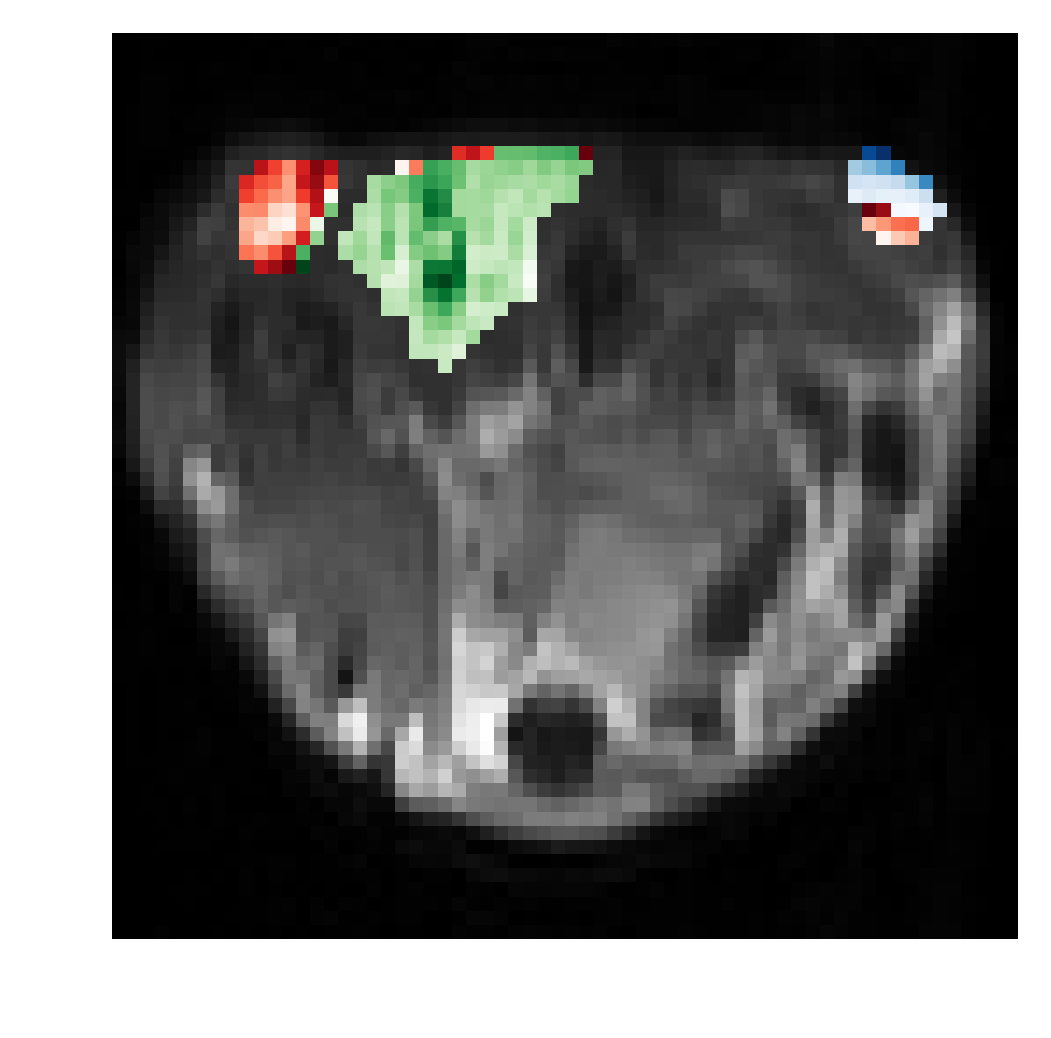

In [36]:
from matplotlib import colors
figure(figsize=(12,6))
figure(dpi=300)
imshow(fliplr(cestData[-1,-1]), origin = 'lower')
gray()
# plt.clim(0, 1)
# plt.colorbar()
# cmap = colors.ListedColormap(['blue'])
maskedRoi = ma.masked_array(cestData[-1,-1], mask=(map_Pred_Right_Tumor_cnn==0))
imshow(fliplr(maskedRoi), cmap='Blues_r', origin = 'lower')

cmap = colors.ListedColormap(['red'])
maskedRoi = ma.masked_array(cestData[-1,-1], mask=(map_Pred_Right_False_Left_Tumor_cnn==0))
imshow(fliplr(maskedRoi),cmap='Reds_r', origin = 'lower')

cmap = colors.ListedColormap(['green'])
maskedRoi = ma.masked_array(cestData[-1,-1], mask=(map_Pred_Right_False_Tissue_Tumor_cnn==0))
imshow(fliplr(maskedRoi),cmap='Greens_r', origin = 'lower')

#---------------------------------------------------
cmap = colors.ListedColormap(['red'])
maskedRoi = ma.masked_array(cestData[-1,-1], mask=(map_Pred_Left_Tumor_cnn==0))
imshow(fliplr(maskedRoi),cmap='Reds_r', origin = 'lower')

cmap = colors.ListedColormap(['blue'])
maskedRoi = ma.masked_array(cestData[-1,-1], mask=(map_Pred_Left_False_Right_Tumor_cnn==0))
imshow(fliplr(maskedRoi), cmap='Blues_r', origin = 'lower')

cmap = colors.ListedColormap(['green'])
maskedRoi = ma.masked_array(cestData[-1,-1], mask=(map_Pred_Left_False_Tissue_Tumor_cnn==0))
imshow(fliplr(maskedRoi),cmap='Greens_r', origin = 'lower')

#---------------------------------------------------
cmap = colors.ListedColormap(['green'])
maskedRoi = ma.masked_array(cestData[-1,-1], mask=(map_Pred_Tissue_cnn==0))
imshow(fliplr(maskedRoi),cmap='Greens_r', origin = 'lower')

cmap = colors.ListedColormap(['blue'])
maskedRoi = ma.masked_array(cestData[-1,-1], mask=(map_Pred_Tissue_False_Right_Tumor_cnn==0))
imshow(fliplr(maskedRoi), cmap='Blues_r', origin = 'lower')

cmap = colors.ListedColormap(['red'])
maskedRoi = ma.masked_array(cestData[-1,-1], mask=(map_Pred_Tissue_False_Left_Tumor_cnn==0))
imshow(fliplr(maskedRoi),cmap='Reds_r', origin = 'lower')

axis('off')